In [ ]:
# Using tensorflow-constrained-optimizaiton library to obtains a mixture of Gaussian which approximates a given cactus distribution.
# Last Update: 12/09/2021 by Fei

In [17]:
import math
import numpy as np
import pandas as pd
from six.moves import xrange
import tensorflow as tf
import tensorflow_probability as tfp
import csv
import tensorflow_constrained_optimization as tfco
import math as m

# set parameters
sen = 1
variance = 1
mixture_number = 11
r = 0.9
iter_num = 1000
learning_rate = 0.005

xmax = 8
np_x = np.linspace(-xmax,xmax,3200)
tf_x = tf.constant(np_x.reshape([len(np_x),1]),dtype=tf.float32)

tf.print(tf_x)

tf.print("Initialization...")

# Create variables containing the model parameters.
variance = tf.constant(variance,dtype = tf.float32)

mu = tf.Variable([np.linspace(-4*np.sqrt(variance),4*np.sqrt(variance),mixture_number)], dtype=tf.float32, name="mu")
tf.print("mu=",mu)

sigma = tf.Variable(tf.ones([1,mixture_number]), dtype=tf.float32, name="sigma")
tf.print("sigma=",sigma)

weights = tf.Variable([[1/mixture_number]*mixture_number], dtype=tf.float32, name="weights", constraint = lambda x:tf.abs(x))
tf.print("weight=",weights)

# define the loss function

@tf.function
def loss_fn():
  w=tf.reduce_sum(weights)
  pred = tf.matmul(1/tf.sqrt(2*np.pi)/sigma*tf.exp(-tf.square(tf_x-mu)/2/tf.square(sigma)),tf.transpose(weights/w))
  pred2 = tf.matmul(1/tf.sqrt(2*np.pi)/sigma*tf.exp(-tf.square(tf_x-mu-sen)/2/tf.square(sigma)),tf.transpose(weights/w))
  loss = tf.reduce_sum((pred-pred2)*tf.math.log(pred/pred2))
  return loss

# define the optimization problem

class ExampleProblem(tfco.ConstrainedMinimizationProblem):

  def __init__(self, mu, sigma, weights):
    self._mu = mu
    self._weights = weights
    self._sigma = sigma

  @property
  def num_constraints(self):
    return 1

  def objective(self):
    return loss_fn()

  def constraints(self):
    mu = self._mu
    sigma = self._sigma
    weights = self._weights
    w=tf.reduce_sum(weights)
    con1 = tf.matmul(tf.pow(sigma,2)+tf.pow(mu,2),tf.transpose(weights/w)) - tf.pow(tf.matmul(mu,tf.transpose(weights/w)),2)-variance
    return tf.concat([con1],axis=1)
#     return con1

# Initialize the optimization problem

problem = ExampleProblem(mu = mu, sigma = sigma, weights=weights)

# Initialize the training setup

if tf.executing_eagerly():
  optimizer = tfco.LagrangianOptimizerV2(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    num_constraints=problem.num_constraints)
 
  # Define a list of trainable variables

  var_list = ([mu,sigma,weights] + list(problem.trainable_variables) +
                optimizer.trainable_variables())
    
  tf.print("start training...")
  
  for ii in xrange(iter_num):
    optimizer.minimize(problem, var_list=var_list)
    if ii%100==0:
      tf.print("round=",ii,"loss =",loss_fn())

  tf.print("training completed.")
  
  mu_np = mu.numpy()
  sigma_np = sigma.numpy()
  weights_np = (weights/tf.reduce_sum(weights)).numpy()
  tf.print("mu=",mu)
  tf.print("sigma=",sigma)
  tf.print("weights=",weights)
  print("sum of weights is", np.sum(weights_np))
  
  filename = ('privacy_data/gaussian_%d_d%.1f_v%.2f.csv' %(mixture_number, sen, variance))
  np.savetxt(filename, np.stack((mu_np.reshape(-1), sigma_np.reshape(-1), weights_np.reshape(-1))), delimiter=',')
  print("result saved.")
  

[[-8]
 [-7.99499846]
 [-7.98999691]
 ...
 [7.98999691]
 [7.99499846]
 [8]]
Initialization...
mu= [[-4 -3.2 -2.4 ... 2.4 3.2 4]]
sigma= [[1 1 1 ... 1 1 1]]
weight= [[0.0909090936 0.0909090936 0.0909090936 ... 0.0909090936 0.0909090936 0.0909090936]]
start training...
round= 0 loss = 39.640789
round= 100 loss = 10.8394461
round= 200 loss = 10.7431221
round= 300 loss = 11.292181
round= 400 loss = 11.4016933
round= 500 loss = 12.1150951
round= 600 loss = 12.2702827
round= 700 loss = 12.7607565
round= 800 loss = 13.120121
round= 900 loss = 13.5717373
training completed.
mu= [[-4.43885565 -2.92456317 -2.36105466 ... 3.0539782 4.81408072 7.2855916]]
sigma= [[1.82437086 1.21015787 1.28633964 ... 0.965382397 1.00867736 1.35989821]]
weights= [[0.00119711692 4.06519466e-05 7.36879592e-05 ... 0.155283496 0.31700936 0.864100456]]
sum of weights is 1.0
result saved.


total sample number N =  3201
maximum range xmax =  [8.]
quantization rate n =  [200.]
mixture number is 11
mu =  [-3.5016232  -2.9591072  -1.2256184  -1.4835557  -0.777597    0.13535333
  0.85590273  1.7420648   2.4730897   4.6196165   7.1260967 ]
sigma =  [2.066002   1.2672713  0.9614244  1.0822668  1.0676475  0.7301857
 1.0502048  0.992864   0.97629225 1.1176344  1.1948338 ]
weights =  [4.0363022e-03 9.8023308e-04 2.4277321e-03 3.5936879e-05 2.8496986e-04
 2.1146440e-03 1.8886680e-04 1.5307102e-02 5.8207843e-02 3.0327338e-01
 6.1314297e-01]
variance of mixture is [[4.3608856]]
sum of weights is 1.0


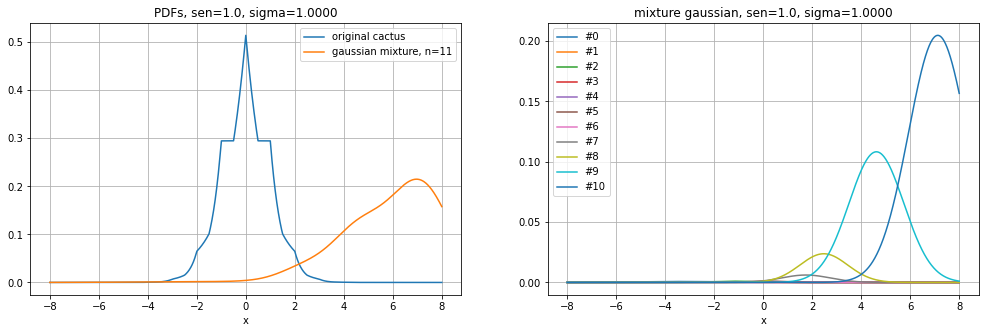

In [14]:
# we plot the obtained pdfs.

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.stats import gaussian_kde
from scipy.stats import norm
import sklearn
from sklearn.neighbors import KernelDensity

# set parameters

sen = 1
variance = 1
mixture_number = 11

# Load cactus distribution files

filename = ('/home/fwei16/privacy_data/cactus_x_d%.1f_v%.2f.csv' %(sen,variance))
cactus_x = np.genfromtxt(filename, dtype=np.float32)
cactus_x = cactus_x.reshape([len(cactus_x),1])

N = len(cactus_x)
print('total sample number N = ',N)

xmax = max(cactus_x)
print('maximum range xmax = ',xmax)

n = N//xmax//2
print('quantization rate n = ',n)

filename = ('/home/fwei16/privacy_data/cactus_p_d%.1f_v%.2f.csv' %(sen,variance))
cactus_pdf = np.genfromtxt(filename, dtype=np.float32)*n
cactus_pdf = cactus_pdf.reshape([len(cactus_pdf),1])


# Load mixture gaussian approximation of the cactus above

filename = ('privacy_data/gaussian_%d_d%.1f_v%.2f.csv' %(mixture_number, sen, variance))
[mu_np,sigma_np,weights_np] = np.genfromtxt(filename, dtype=np.float32,delimiter=',')
print("mixture number is", mixture_number)
print("mu = ", mu_np)
print("sigma = ", sigma_np)
print("weights = ", weights_np)

mu_np = mu_np.reshape((1,mixture_number))
sigma_np = sigma_np.reshape((1,mixture_number))
weights_np = weights_np.reshape((1,mixture_number))

varMix = np.matmul(np.power(sigma_np,2)+np.power(mu_np,2),np.transpose(weights_np)) - np.sum(weights_np*mu_np)**2
print("variance of mixture is", varMix)

print("sum of weights is", np.sum(weights_np))


# this is the optimization-obtained mixture gaussian pdf

opt_pdf =np.matmul(1/np.sqrt(2*np.pi)/sigma_np*np.exp(-np.square(cactus_x-mu_np)/2/np.square(sigma_np)),np.transpose(weights_np))


# this is the elements of the mixture gaussian pdf

mix_pdf=[]
for i in range(mixture_number):
    temp = 1/np.sqrt(2*np.pi)/sigma_np[0][i]*np.exp(-np.square(cactus_x-mu_np[0][i])/2/np.square(sigma_np[0][i]))*weights_np[0][i]
    mix_pdf.append(temp)

# PLOTS

plt.figure(figsize=(17, 5))

# original/kernel density/gassian mixture

plt.subplot(1,2,1)
plt.plot(cactus_x,cactus_pdf, label=('original cactus'))
plt.plot(cactus_x,opt_pdf, label=('gaussian mixture, n=%d' %(mixture_number)))
plt.xlabel('x')
plt.title('PDFs, sen=%1.1f, sigma=%.4f' %(sen, np.sqrt(variance)))
plt.legend()
plt.grid(True)


# each element pdf of the gaussian mixture
plt.subplot(1,2,2)
for i in range(mixture_number):
    plt.plot(cactus_x, mix_pdf[i], label=('#%d' %(i)))
plt.xlabel('x')
plt.title('mixture gaussian, sen=%1.1f, sigma=%.4f' %(sen, np.sqrt(variance)))
plt.legend()
plt.grid(True)